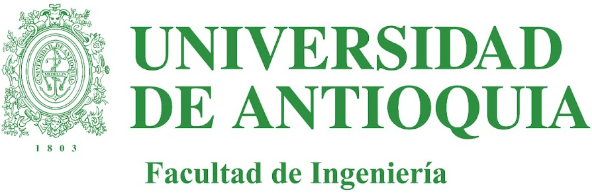

# **Modelos de Variable Latente para el Reconocimiento de Emociones**
## Docente: Hernán Felipe García Arias
## Por: David Alexander Sánchez, Juan Pablo Areiza
### Universidad de Antioquia, Medellín 2023

## Librerías

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from sklearn.decomposition import PCA , KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## PCA

In [3]:
df = pd.read_csv('features.csv', index_col=False)

# Características y las etiquetas emocionales
X = df.iloc[:, 2:]  # Ignorar la primera columna y las etiquetas
y = df['Emociones']

# Codificación de las etiquetas emocionales en números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Se normalizan las características
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

### Espacio latente

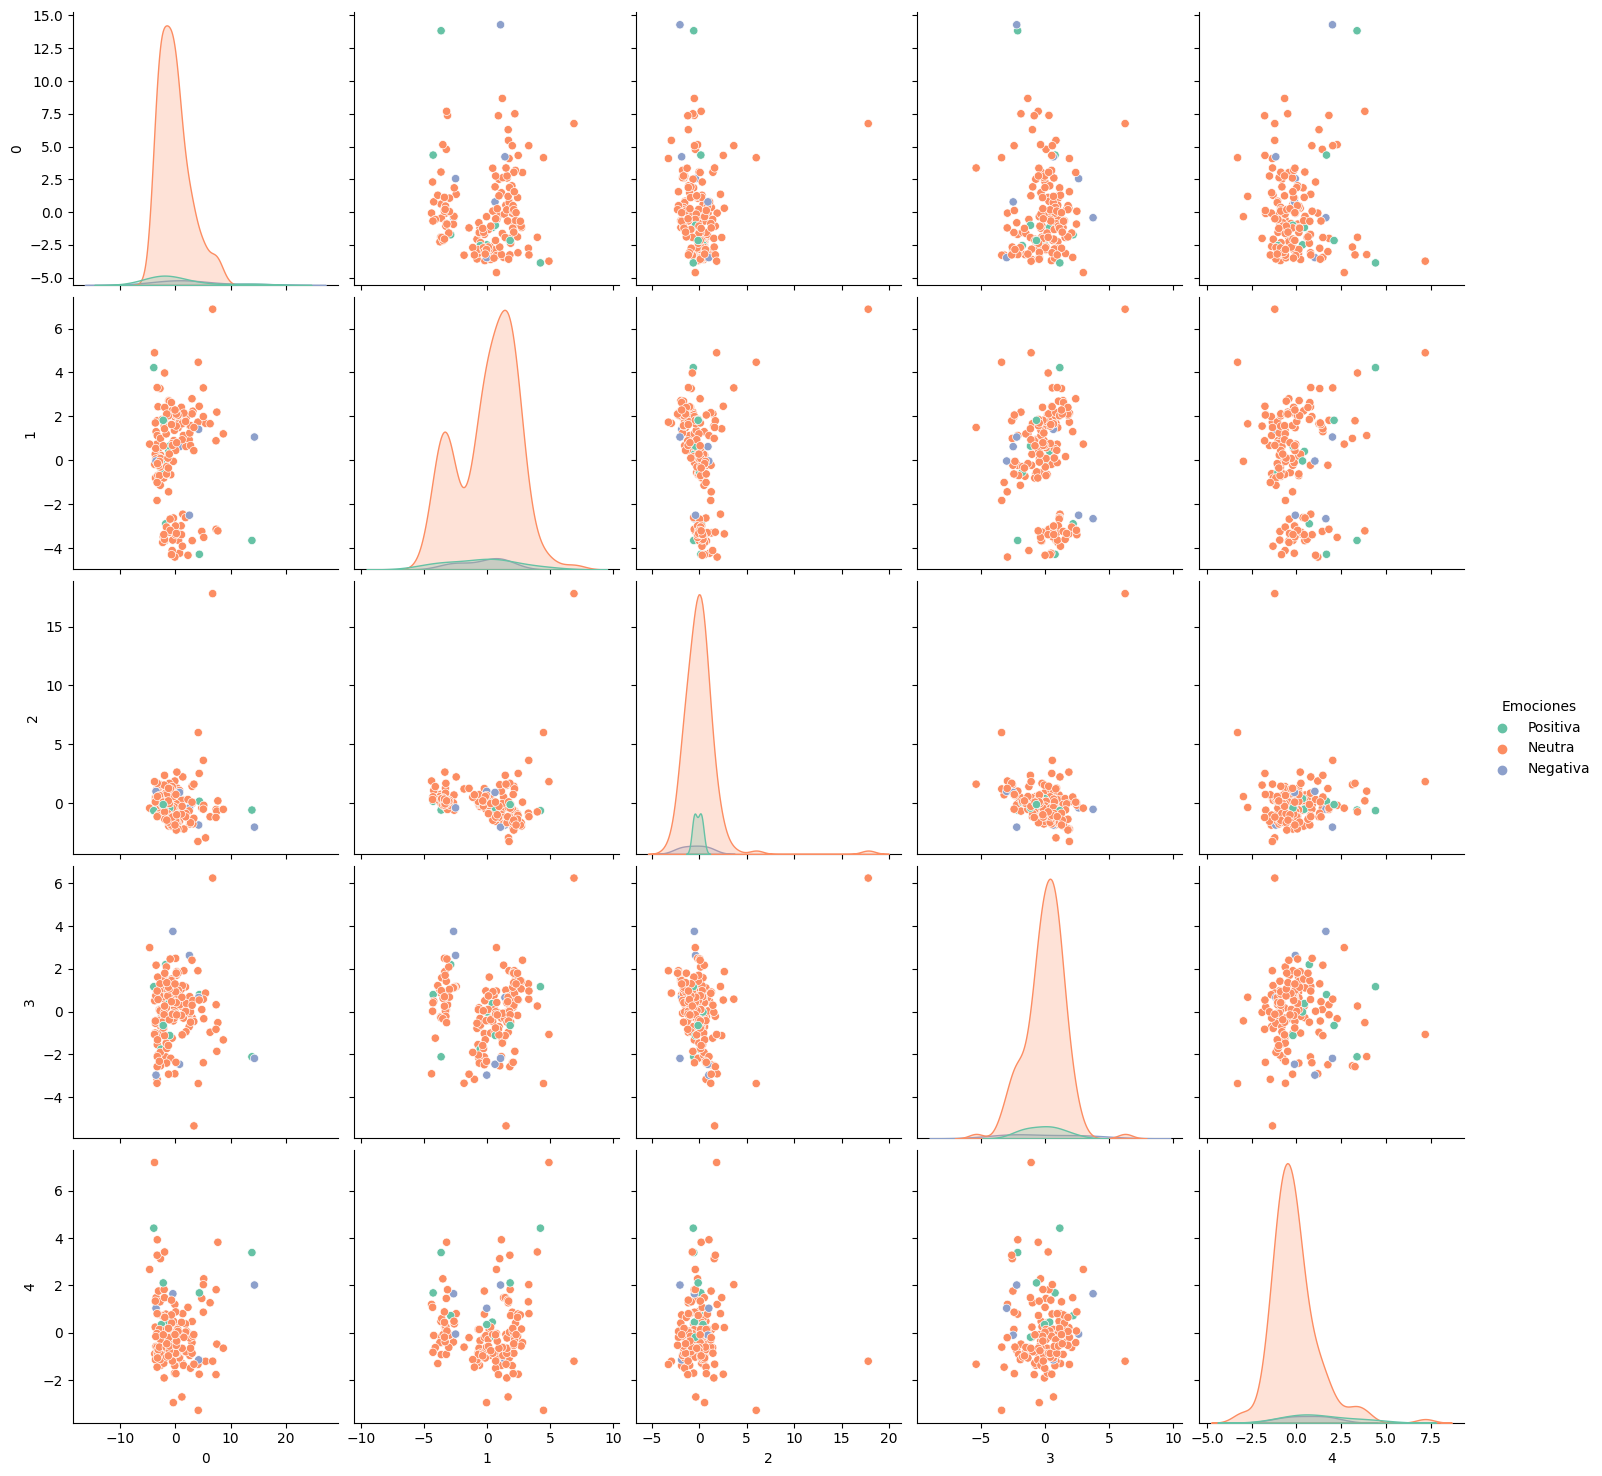

In [10]:
pca = PCA(n_components=5) #Espacio latente con 5 componentes
X_pca = pca.fit_transform(X_normalized) # Transformación de los datos al espacio latente

df_pca = pd.DataFrame(data=X_pca)
df_pca['Emociones'] = y
sns.pairplot(df_pca, hue="Emociones", height=3, palette = sns.color_palette("Set2",3))

En el espacio latente, se observa una distinción muy pequeña entre emociones positivas y negativas. Sin embargo, con las emociones neutras se podía apreciar una diferencia más clara en dos grupos de esta emoción. Esta situación se repite al ver los gráficos de las componentes 1 y 2, así como de las componentes 2 y 4, y en menor medida de las componentes 2 y 5. Esto podría indicar que existen dos subgrupos distintos en los datos, debido al criterio para determinar una emoción neutra basado en Arousal y Valence, o a la influencia de una variable numérica en la ubicación de los puntos naranjas.


### Modelos de clasificación

Se realiza un código interactivo en la construcción del módulo de variable latente utilizando PCA en el contexto del análisis multivariado de las señales fisiológicas. Para comparar el rendimiento de la calisficación, se plantea entrenar modelos lineales de clasificación, como Mínimos Cuadrados, Bayesiano y Regresión Logística, con el propósito de evaluar su rendimiento en el reconocimiento de los tipos de emociones.


El código interactivo permite seleccionar el espacio de visualización de los datos (PCA o Entrada). También se dispone de una variable llamada "n_components" que permite variar la cantidad de componentes en el espacio latente, teniendo en cuenta como límite superior el número total de características extraídas (38).

In [20]:
@interact(PCA_flag=[True,False],n_components=(1,38,1), model=["Mínimos_Cuadrados", "Bayesiano", "Regresion_Logstica"]) #Número de componentes máximo corresponde a la cantidad de características extraídas
def pca(PCA_flag, n_components, model):
  perc = (n_components/38) * 100
  print(f"Percent variables used: {np.round(perc,3)}%")

  # Análisis de Componentes Principales (PCA)
  pca = PCA(n_components=int(n_components))
  X_pca = pca.fit_transform(X_normalized) # Transformación de los datos al espacio latente
  df_pca = pd.DataFrame(data=X_pca)
  print("Original shape: ", X.shape)
  print("Transformed shape: ", X_pca.shape)


  if(PCA_flag==True):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, random_state=0, test_size=0.3)
  else:
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, random_state=0, test_size=0.3)

  if(model=="Mínimos_Cuadrados"):
    # Modelo de Mínimos Cuadrados
    clasificadorMC = LinearRegression()
    clasificadorMC.fit(X_train, y_train)
    # Predicción (redondear a la clase más cercana)
    y_pred = np.round(clasificadorMC.predict(X_test)).astype(int)

  elif(model=="Bayesiano"):
    # Modelo Bayesiano
    clasificadorBayes = GaussianNB()
    clasificadorBayes.fit(X_train,y_train)
    # Predicción
    y_pred = clasificadorBayes.predict(X_test)

  else:
    # Modelo de Regresión Logística
    clasificadorRL = LogisticRegression()
    clasificadorRL.fit(X_train, y_train)
    # Predicción
    y_pred = clasificadorRL.predict(X_test)


  # Accuracy y matriz de confusión
  CMAT = confusion_matrix(y_test,y_pred)
  acc = accuracy_score(y_test, y_pred) * 100
  print()
  print(f'Accuracy: {acc}%')

  if(PCA_flag==True):
    # Espacio latente 2 componentes
    colors = ['r', 'c', 'g']  # Rojo para negativa, cian para neutra, verde para positiva

    plt.figure(figsize=(15, 5))

    # Subplot 1: Espacio latente 2 componentes
    plt.subplot(1, 2, 1)
    for i, emotion in enumerate(df['Emociones'].unique()):
        subset = df_pca[y_encoded == i]
        plt.scatter(subset[0], subset[1], label=emotion, color=colors[i]) #Se presenta la componente 1 y la 2 por la división en dos subgrupos de emociones neutras

    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.title(f'PCA con q={n_components} - Accuracy: {acc:.2f}')

    # Subplot 2: Matriz
    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(pca.explained_variance_) / np.sum(pca.explained_variance_))
    plt.title('Var explained normalized')
    plt.grid()

    plt.tight_layout()  # Ajusta automáticamente los subplots para evitar solapamientos
    plt.show()

  ax = ConfusionMatrixDisplay(confusion_matrix=CMAT, display_labels=np.unique(y_encoded))
  ax.plot()
  plt.show()

interactive(children=(Dropdown(description='PCA_flag', options=(True, False), value=True), IntSlider(value=19,…

### Resultados

Sin utilizar PCA:

- Mínimos Cuadrados: Accuracy del 72.916%
- Bayesiano: Accuracy del 79.166%
- Regresión Logística: Accuracy del 75%

Utilizando PCA:

- Mínimos Cuadrados: Accuracy del 85.416% con 4 componentes principales
- Bayesiano: Accuracy del 89.583% con 12 componentes principales
- Regresión Logística: Accuracy del 85.416% con 4 componentes principales

### Observaciones

- En todos los modelos, la utilización de PCA ha llevado a un aumento en el accuracy en comparación con el uso de la matriz de características original. Esto sugiere que la proyección a un espacio latente de menor dimensión ha capturado de manera efectiva la información relevante para la clasificación.

- En el caso de Mínimos Cuadrados y Regresión Logística, se logra un alto accuracy con un número reducido de componentes (4).
Para el modelo Bayesiano, el rendimiento sigue mejorando con un mayor número de componentes (al menos hasta 12). Esto puede indicar que el modelo bayesiano se beneficia de una representación más rica de las características.

- El modelo bayesiano logra el mayor accuracy en ambos escenarios (sin PCA y con PCA). Puede ser más robusto para manejar la complejidad de los datos.

- Adicionalmente, se consideró preservar el 90% de la varianza presente en los datos, por lo que se determinó el uso de 15 componentes principales, obteniendo una reducción del 60.53% en la dimensionalidad. Este número de componentes  ofrece ventajas significativas, como modelos de aprendizaje automático más sencillos y menor riesgo de sobreajuste. Con esta cantidad de componentes se obtuvo los siguientes resultados:
  - Mínimos Cuadrados: Accuracy del 83.333%
  - Bayesiano: Accuracy del 85.416%
  - Regresión Logística: Accuracy del 79.166%


## KPCA

### Espacio latente

Se realiza la reducción de dimensionalidad utilizando 12 componentes y el Kernel 'rbf' con gamma = 8. Se emplea este kernel porque puede adaptarse mejor a los patrones más complejos y no lineales como los del conjunto de datos.

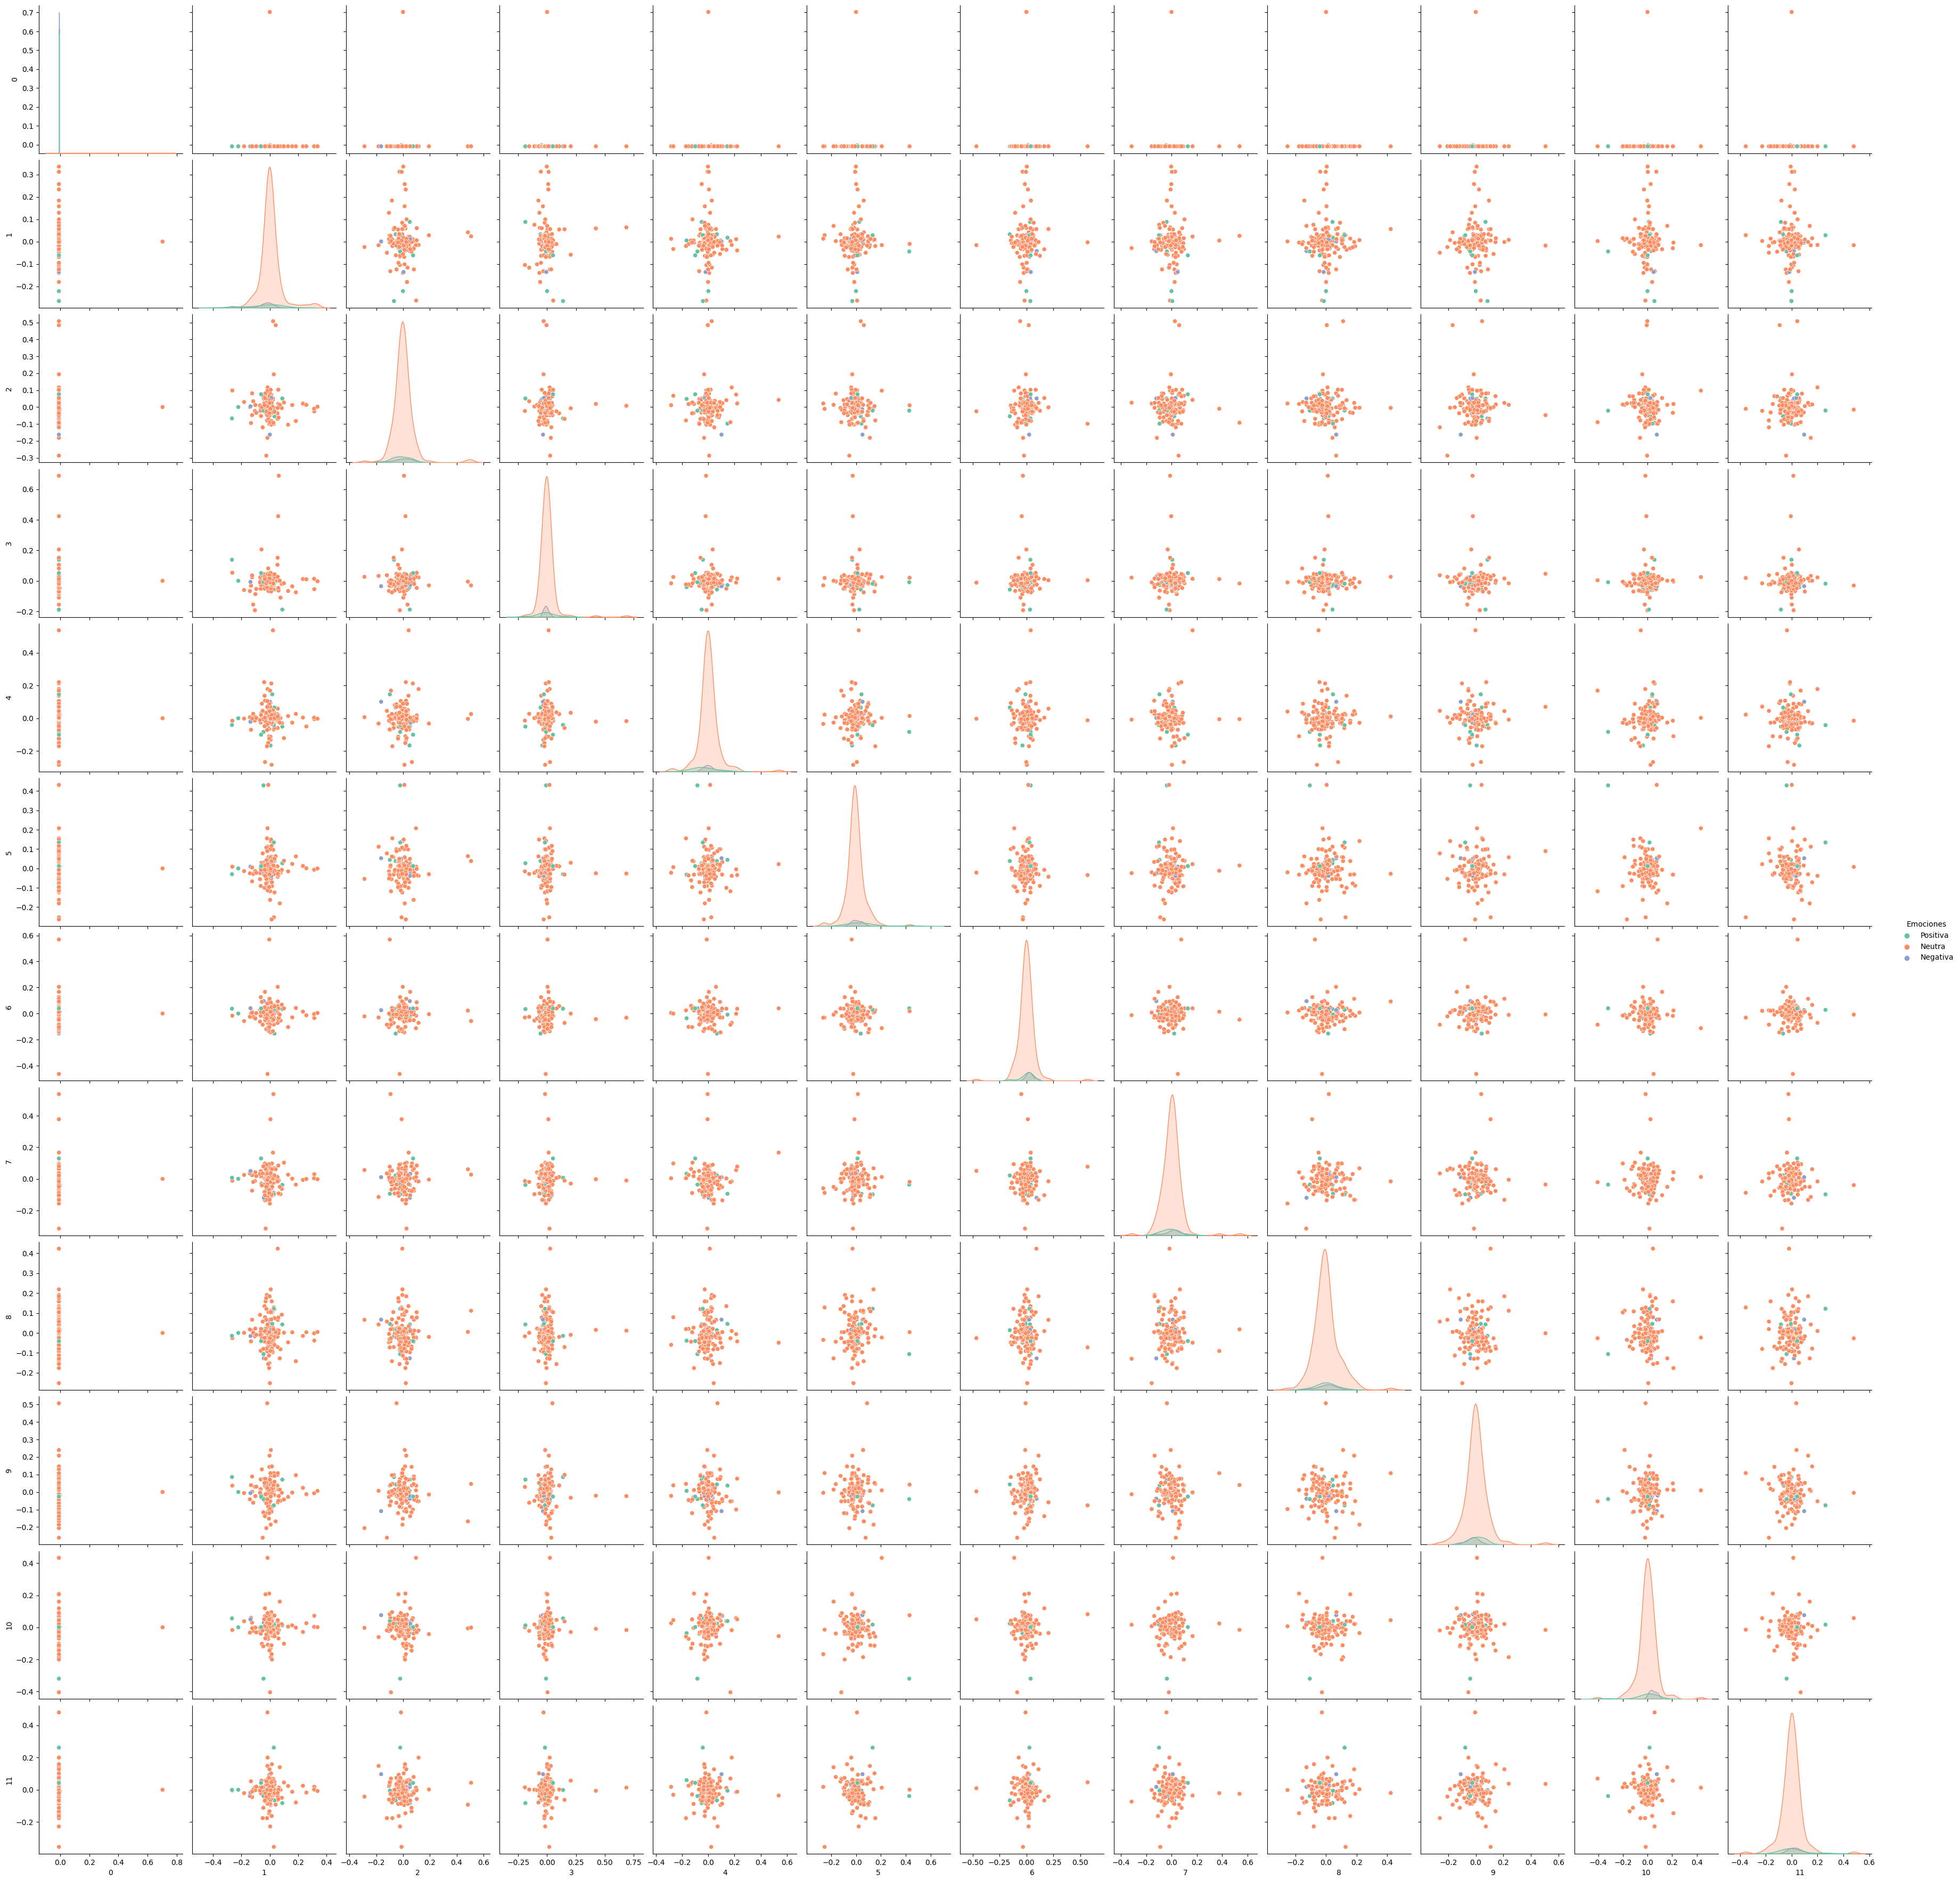

In [22]:
kpca = KernelPCA(n_components=12, kernel='rbf',gamma=8)
X_kpca = kpca.fit_transform(X_normalized) # Transformación de los datos al espacio latente

df_kpca = pd.DataFrame(data=X_kpca)
df_kpca['Emociones'] = y
sns.pairplot(df_kpca, hue="Emociones", height=3, palette = sns.color_palette("Set2",3))

Al comparar con PCA, se logra observar que KPCA permite diferenciar de mejor manera las emociones positivas del resto de emociones, ya que al tratarse el conjunto de datos de una estructura no lineal, se puede capturar esas relaciones más complejas lo que permite evidenciar una mejor separación.

### Reducción de dimensionalidad

Se realiza un código interactivo en la construcción del módulo de variable latente utilizando KPCA, probando diferentes kernels y variando los hiperparámetros. Para comparar el rendimiento de la calisficación, se  entrena un modelo de clasificación de Regresión Logística para e reconocimiento de los tipos de emociones.

El código interactivo permite seleccionar el espacio de visualización de los datos (PCA, KPCA o Entrada). También se dispone de una variable llamada "n_components" que permite variar la cantidad de componentes en el espacio latente, teniendo en cuenta como límite superior el número total de características extraídas (38). Con la variable "k" se puede variar el kernel y los hiperparámetros como gamma y degree dependiendo del kernel.

In [11]:
@interact(PCA_flag=[True, False], KPCA_flag=[True, False], n_components=(1, 38, 1), k=['linear', 'poly', 'rbf', 'sigmoid', 'cosine'],gamma=[0.001, 0.01, 0.1, 1, 5, 10, 50, 100], degree=(1,10,1))
def pca_kpca(PCA_flag, KPCA_flag, n_components, k,gamma,degree):
    perc = (n_components / 38) * 100
    print(f"Percent variables used: {np.round(perc, 3)}%")

    # PCA
    if PCA_flag:
        pca = PCA(n_components=int(n_components))
        X_pca = pca.fit_transform(X_normalized)
        df_pca = pd.DataFrame(data=X_pca)
        print("PCA - Original shape: ", X_normalized.shape)
        print("PCA - Transformed shape: ", X_pca.shape)
    else:
        df_pca = df

    # KPCA
    if KPCA_flag:
        if k=='poly':
          kpca = KernelPCA(n_components=int(n_components), kernel=k, degree=degree)
        elif (k=='linear' or k=='cosine'):
          kpca = KernelPCA(n_components=int(n_components), kernel=k)
        else:
          kpca = KernelPCA(n_components=int(n_components), kernel=k,gamma=gamma)

        X_kpca = kpca.fit_transform(X_normalized)
        df_kpca = pd.DataFrame(data=X_kpca)
        print("KPCA - Original shape: ", X_normalized.shape)
        print("KPCA - Transformed shape: ", X_kpca.shape)
    else:
        df_kpca = df_pca  # Usa el DataFrame PCA si KPCA_flag es False

    colors = ['r', 'c', 'g']
    # Visualización de PCA y KPCA
    plt.figure(figsize=(15, 5))

    # Subplot 1: PCA
    plt.subplot(1, 2, 1)
    for i, emotion in enumerate(df['Emociones'].unique()):
        subset = df_pca[y_encoded == i]
        plt.scatter(subset[0], subset[1], label=emotion, color=colors[i])  # Se presenta la componente 1 y la 2

    plt.xlabel('PCA - Componente Principal 1')
    plt.ylabel('PCA - Componente Principal 2')
    plt.legend()
    plt.title(f'PCA with q={n_components}')

    # Subplot 2: KPCA
    plt.subplot(1, 2, 2)
    for i, emotion in enumerate(df['Emociones'].unique()):
        subset = df_kpca[y_encoded == i]
        plt.scatter(subset[0], subset[1], label=emotion, color=colors[i])  # Se presenta la componente 1 y la 2

    plt.xlabel('KPCA - Componente Principal 1')
    plt.ylabel('KPCA - Componente Principal 2')
    plt.legend()
    plt.title(f'KPCA with q={n_components}')

    plt.tight_layout()
    plt.show()

    # Subconjunto de datos transformados por KPCA
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(df_kpca, y_encoded, random_state=0, test_size=0.3)

    # Clasificador basado en Regresión Logística con KPCA
    clasificadorRL_kpca = LogisticRegression()
    clasificadorRL_kpca.fit(X_train_kpca, y_train_kpca)
    y_pred_kpca = clasificadorRL_kpca.predict(X_test_kpca)

    # Evaluación del desempeño del clasificador con KPCA
    CMAT_kpca = confusion_matrix(y_test_kpca, y_pred_kpca)
    acc_kpca = accuracy_score(y_test_kpca, y_pred_kpca) * 100
    print()
    print(f'Regression Logstica con KPCA - Accuracy: {acc_kpca}%')

    # Matriz de Confusión con KPCA
    ax_kpca = ConfusionMatrixDisplay(confusion_matrix=CMAT_kpca, display_labels=np.unique(y_encoded))
    ax_kpca.plot()
    plt.show()

interactive(children=(Dropdown(description='PCA_flag', options=(True, False), value=True), Dropdown(descriptio…

### Observaciones
- Se decide mantener el análisis con 15 componentes principales para preservar el 90% de la varianza. Esto permite reducir la dimensionalidad mientras retiene la mayoría de la información relevante.

- Para KPCA con un kernel linear, se obtiene el mismo resutado que con PCA. Esto se debe a que el kernel lineal en KPCA se reduce a PCA en sí mismo.

- Los resultados con el kernel cosine, arrojan un accuracy de  85.416%. Este resultado sugiere que este kernel es eficaz para capturar patrones no lineales específicos presentes en los datos.

- Los resultados con el kernel poly con un grado de polinomio de 2, 3, 4 y 5, arroja un accuracy de  83.333%. El resultado indica que el kernel polinomial podría no estar mejorando significativamente el rendimiento en comparación con otros kernels.

- Los resultados con el kernel rbf arrojaban un accuracy de 85.416% sin importar el gamma, sin embargo, este parámetro modificaba considerablemente la separabilidad de los datos en un gráfico de dispersión. El hecho de que el accuracy sea constante (85.416%) pero que el parámetro gamma afecte la separabilidad en un gráfico de dispersión sugiere que, aunque la clasificación es consistente, la distribución en el espacio latente puede variar.

- El kernel sigmoid también arroja un accuracy de 85.416% sin importar el gamma, además, no se observó diferencia en la forma en cómo se agrupaban los datos en el gráfico de dispersión. Este resultado de accuracy independiente del valor de gamma podría indicar que este parámetro no está influyendo significativamente en el rendimiento del modelo con este kernel específico.

## Conclusiones

- La aplicación de PCA mejora el rendimiento de todos los modelos, indicando que la proyección a un espacio latente de menor dimensión captura información relevante. Mínimos Cuadrados y Regresión Logística alcanzan un alto accuracy con solo 4 componentes principales, sugiriendo una fuerte capacidad de clasificación con dimensionalidad reducida. El modelo bayesiano continúa mejorando con más componentes, destacando su capacidad para aprovechar representaciones más ricas.
- La reducción significativa de dimensionalidad mientras se mantiene el 90% de la varianza indica eficacia en la representación de datos. Los modelos mantienen un rendimiento sólido, destacando la capacidad del modelo bayesiano para adaptarse a dimensiones más altas.
- KPCA destaca en la diferenciación de emociones positivas, sugiriendo que es más capaz de capturar relaciones no lineales complejas que PCA. El kernel cosine muestra un rendimiento efectivo con un accuracy del 85.416%, indicando su capacidad para capturar patrones no lineales específicos. El kernel RBF muestra consistencia en el accuracy, pero el impacto del parámetro gamma en la separabilidad destaca la importancia de ajustar hiperparámetros.
- Se observa una pequeña distinción entre emociones positivas y negativas en el espacio latente, pero una clara diferencia en dos grupos de emociones neutras. La dificultad para distinguir entre emociones positivas y negativas puede deberse a la estructura lineal de PCA. KPCA muestra una mayor capacidad para separar estas emociones, lo que podría indicar una mayor complejidad no lineal en los datos.
- Se demuestra la utilidad de las técnicas de reducción de dimensionalidad para extraer información relevante y facilitar la clasificación de emociones. Por otro lado, se evidencia la importancia de elegir el método adecuado en función de la complejidad no lineal de los datos y los objetivos específicos del análisis. Además, se destaca la adaptabilidad y el rendimiento robusto de los modelos bayesianos en diferentes configuraciones.
- La evaluación coherente de matrices de confusión respalda los resultados de accuracy, proporcionando una validación adicional de la eficacia de los enfoques empleados.

